In [1]:
import numpy as np
import matplotlib.pyplot as plt


from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, log_loss, accuracy_score

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense,Flatten,GlobalAveragePooling2D,Conv2D,MaxPooling2D,Activation,Dropout


import warnings
warnings.filterwarnings('ignore')

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, CarliniLInfMethod, DeepFool
from art.attacks.evasion import FeatureAdversariesTensorFlowV2
from art.estimators.classification import TensorFlowV2Classifier
if tf.__version__[0] != '2':
    raise ImportError('This notebook requires TensorFlow v2.')

In [7]:
lfw_dataset=fetch_lfw_people(min_faces_per_person=100)

print(lfw_dataset.images.shape)
print(lfw_dataset.data.shape)
print(lfw_dataset.target_names.shape)
print(lfw_dataset.target.shape)

lfw_dataset.target

Name = lfw_dataset.target_names

print(Name)
print(len(Name))

N=[]
for i in range(len(Name)):
    N+=[i]
    
mapping=dict(zip(Name,N)) 
reverse_mapping=dict(zip(N,Name)) 

def mapper(value):
    return reverse_mapping[value]

X0=lfw_dataset.images
y=lfw_dataset.target

print(X0.shape)
X=X0.reshape(-1,62,47,1)
print(X.shape)

dataset=[]
testset=[]
t=0
for Xi,yi in zip(X,y):
    img=Xi/255.0
    if t<=200:
        dataset.append([img,yi])
    else:   
        testset.append([img,yi])
    t+=1

data,labels0=zip(*dataset)
test,tlabels0=zip(*testset)

labels1=to_categorical(labels0)
data=np.array(data)
labels=np.array(labels1)

tlabels1=to_categorical(tlabels0)
test=np.array(test)
tlabels=np.array(tlabels1)

# trainx,testx,trainy,testy=train_test_split(data,labels,test_size=0.2,random_state=44)
trainx,testx,trainy,testy=train_test_split(data,labels,test_size=0.2,random_state=1)

x_train = trainx.astype(np.float32)
x_test = testx.astype(np.float32)
y_train = trainy.astype(np.float32)
y_test = testy.astype(np.float32)

print(trainx.shape)
print(testx.shape)
print(trainy.shape)
print(testy.shape)

(1140, 62, 47)
(1140, 2914)
(5,)
(1140,)
['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']
5
(1140, 62, 47)
(1140, 62, 47, 1)
(160, 62, 47, 1)
(41, 62, 47, 1)
(160, 5)
(41, 5)


In [8]:
# datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=20,zoom_range=0.2,
#                     width_shift_range=0.2,height_shift_range=0.2,shear_range=0.1,fill_mode="nearest")

model = Sequential()

model.add(Conv2D(32,(3,3), input_shape=(62,47,1), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32,(3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=5, activation='softmax'))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 60, 45, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 22, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 20, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 10, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 4480)              0         
                                                                 
 dense_6 (Dense)             (None, 512)              

In [9]:
model.fit(trainx,trainy, validation_data=(testx,testy),epochs=1000, batch_size=32)

Train on 160 samples, validate on 41 samples
Epoch 1/1000


2023-05-16 18:32:49.812324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-16 18:32:49.841995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-16 18:32:49.940173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-16 18:32:49.947293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - 0s 2ms/sample - loss: 1.4879 - accuracy: 0.4188 - val_loss: 1.4396 - val_accuracy: 0.4390
Epoch 2/1000
 96/160 [=================>............] - ETA: 0s - loss: 1.3664 - accuracy: 0.4896

2023-05-16 18:32:50.217900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - 0s 1ms/sample - loss: 1.3976 - accuracy: 0.4750 - val_loss: 1.5121 - val_accuracy: 0.4390
Epoch 3/1000
160/160 [==============================] - 0s 1ms/sample - loss: 1.3797 - accuracy: 0.4750 - val_loss: 1.4353 - val_accuracy: 0.4390
Epoch 4/1000
160/160 [==============================] - 0s 1ms/sample - loss: 1.3786 - accuracy: 0.4750 - val_loss: 1.4351 - val_accuracy: 0.4390
Epoch 5/1000
160/160 [==============================] - 0s 834us/sample - loss: 1.3539 - accuracy: 0.4750 - val_loss: 1.3936 - val_accuracy: 0.4390
Epoch 6/1000
160/160 [==============================] - 0s 924us/sample - loss: 1.2942 - accuracy: 0.4750 - val_loss: 1.4538 - val_accuracy: 0.4878
Epoch 7/1000
160/160 [==============================] - 0s 950us/sample - loss: 1.2439 - accuracy: 0.5813 - val_loss: 1.3088 - val_accuracy: 0.4878
Epoch 8/1000
160/160 [==============================] - 0s 1ms/sample - loss: 1.1834 - accuracy: 0.5563 - val_loss: 1.2265 - val_ac

160/160 [==============================] - 0s 720us/sample - loss: 9.6162e-04 - accuracy: 1.0000 - val_loss: 0.5537 - val_accuracy: 0.8780
Epoch 58/1000
160/160 [==============================] - 0s 714us/sample - loss: 9.3653e-04 - accuracy: 1.0000 - val_loss: 0.5583 - val_accuracy: 0.8780
Epoch 59/1000
160/160 [==============================] - 0s 697us/sample - loss: 8.9035e-04 - accuracy: 1.0000 - val_loss: 0.5545 - val_accuracy: 0.8780
Epoch 60/1000
160/160 [==============================] - 0s 655us/sample - loss: 8.6314e-04 - accuracy: 1.0000 - val_loss: 0.5519 - val_accuracy: 0.8780
Epoch 61/1000
160/160 [==============================] - 0s 714us/sample - loss: 8.3990e-04 - accuracy: 1.0000 - val_loss: 0.5641 - val_accuracy: 0.8537
Epoch 62/1000
160/160 [==============================] - 0s 720us/sample - loss: 7.9941e-04 - accuracy: 1.0000 - val_loss: 0.5640 - val_accuracy: 0.8780
Epoch 63/1000
160/160 [==============================] - 0s 707us/sample - loss: 7.6772e-04 - ac

160/160 [==============================] - 0s 708us/sample - loss: 2.2569e-04 - accuracy: 1.0000 - val_loss: 0.6184 - val_accuracy: 0.8780
Epoch 111/1000
160/160 [==============================] - 0s 711us/sample - loss: 2.2270e-04 - accuracy: 1.0000 - val_loss: 0.6180 - val_accuracy: 0.8780
Epoch 112/1000
160/160 [==============================] - 0s 696us/sample - loss: 2.1725e-04 - accuracy: 1.0000 - val_loss: 0.6177 - val_accuracy: 0.8780
Epoch 113/1000
160/160 [==============================] - 0s 662us/sample - loss: 2.1395e-04 - accuracy: 1.0000 - val_loss: 0.6192 - val_accuracy: 0.8780
Epoch 114/1000
160/160 [==============================] - 0s 671us/sample - loss: 2.0966e-04 - accuracy: 1.0000 - val_loss: 0.6205 - val_accuracy: 0.8780
Epoch 115/1000
160/160 [==============================] - 0s 706us/sample - loss: 2.0491e-04 - accuracy: 1.0000 - val_loss: 0.6240 - val_accuracy: 0.8780
Epoch 116/1000
160/160 [==============================] - 0s 722us/sample - loss: 2.0326e-0

160/160 [==============================] - 0s 651us/sample - loss: 9.7258e-05 - accuracy: 1.0000 - val_loss: 0.6575 - val_accuracy: 0.8537
Epoch 164/1000
160/160 [==============================] - 0s 673us/sample - loss: 9.5284e-05 - accuracy: 1.0000 - val_loss: 0.6585 - val_accuracy: 0.8780
Epoch 165/1000
160/160 [==============================] - 0s 683us/sample - loss: 9.4451e-05 - accuracy: 1.0000 - val_loss: 0.6621 - val_accuracy: 0.8780
Epoch 166/1000
160/160 [==============================] - 0s 677us/sample - loss: 9.2896e-05 - accuracy: 1.0000 - val_loss: 0.6628 - val_accuracy: 0.8780
Epoch 167/1000
160/160 [==============================] - 0s 761us/sample - loss: 9.1502e-05 - accuracy: 1.0000 - val_loss: 0.6631 - val_accuracy: 0.8780
Epoch 168/1000
160/160 [==============================] - 0s 638us/sample - loss: 9.0297e-05 - accuracy: 1.0000 - val_loss: 0.6629 - val_accuracy: 0.8780
Epoch 169/1000
160/160 [==============================] - 0s 640us/sample - loss: 8.9389e-0

160/160 [==============================] - 0s 724us/sample - loss: 5.2532e-05 - accuracy: 1.0000 - val_loss: 0.6908 - val_accuracy: 0.8780
Epoch 217/1000
160/160 [==============================] - 0s 714us/sample - loss: 5.2020e-05 - accuracy: 1.0000 - val_loss: 0.6920 - val_accuracy: 0.8780
Epoch 218/1000
160/160 [==============================] - 0s 720us/sample - loss: 5.1504e-05 - accuracy: 1.0000 - val_loss: 0.6932 - val_accuracy: 0.8780
Epoch 219/1000
160/160 [==============================] - 0s 788us/sample - loss: 5.0975e-05 - accuracy: 1.0000 - val_loss: 0.6942 - val_accuracy: 0.8537
Epoch 220/1000
160/160 [==============================] - 0s 673us/sample - loss: 5.0616e-05 - accuracy: 1.0000 - val_loss: 0.6928 - val_accuracy: 0.8780
Epoch 221/1000
160/160 [==============================] - 0s 676us/sample - loss: 5.0038e-05 - accuracy: 1.0000 - val_loss: 0.6937 - val_accuracy: 0.8780
Epoch 222/1000
160/160 [==============================] - 0s 642us/sample - loss: 4.9594e-0

160/160 [==============================] - 0s 724us/sample - loss: 3.2533e-05 - accuracy: 1.0000 - val_loss: 0.7178 - val_accuracy: 0.8780
Epoch 270/1000
160/160 [==============================] - 0s 783us/sample - loss: 3.2236e-05 - accuracy: 1.0000 - val_loss: 0.7189 - val_accuracy: 0.8780
Epoch 271/1000
160/160 [==============================] - 0s 749us/sample - loss: 3.1971e-05 - accuracy: 1.0000 - val_loss: 0.7191 - val_accuracy: 0.8780
Epoch 272/1000
160/160 [==============================] - 0s 702us/sample - loss: 3.1886e-05 - accuracy: 1.0000 - val_loss: 0.7182 - val_accuracy: 0.8780
Epoch 273/1000
160/160 [==============================] - 0s 665us/sample - loss: 3.1519e-05 - accuracy: 1.0000 - val_loss: 0.7193 - val_accuracy: 0.8780
Epoch 274/1000
160/160 [==============================] - 0s 656us/sample - loss: 3.1209e-05 - accuracy: 1.0000 - val_loss: 0.7197 - val_accuracy: 0.8780
Epoch 275/1000
160/160 [==============================] - 0s 652us/sample - loss: 3.0945e-0

160/160 [==============================] - 0s 814us/sample - loss: 2.1783e-05 - accuracy: 1.0000 - val_loss: 0.7405 - val_accuracy: 0.8780
Epoch 323/1000
160/160 [==============================] - 0s 805us/sample - loss: 2.1606e-05 - accuracy: 1.0000 - val_loss: 0.7412 - val_accuracy: 0.8780
Epoch 324/1000
160/160 [==============================] - 0s 735us/sample - loss: 2.1473e-05 - accuracy: 1.0000 - val_loss: 0.7413 - val_accuracy: 0.8780
Epoch 325/1000
160/160 [==============================] - 0s 671us/sample - loss: 2.1298e-05 - accuracy: 1.0000 - val_loss: 0.7424 - val_accuracy: 0.8780
Epoch 326/1000
160/160 [==============================] - 0s 661us/sample - loss: 2.1192e-05 - accuracy: 1.0000 - val_loss: 0.7431 - val_accuracy: 0.8780
Epoch 327/1000
160/160 [==============================] - 0s 677us/sample - loss: 2.1068e-05 - accuracy: 1.0000 - val_loss: 0.7442 - val_accuracy: 0.8780
Epoch 328/1000
160/160 [==============================] - 0s 650us/sample - loss: 2.0877e-0

160/160 [==============================] - 0s 728us/sample - loss: 1.5383e-05 - accuracy: 1.0000 - val_loss: 0.7624 - val_accuracy: 0.8780
Epoch 376/1000
160/160 [==============================] - 0s 717us/sample - loss: 1.5259e-05 - accuracy: 1.0000 - val_loss: 0.7624 - val_accuracy: 0.8780
Epoch 377/1000
160/160 [==============================] - 0s 673us/sample - loss: 1.5193e-05 - accuracy: 1.0000 - val_loss: 0.7631 - val_accuracy: 0.8780
Epoch 378/1000
160/160 [==============================] - 0s 634us/sample - loss: 1.5119e-05 - accuracy: 1.0000 - val_loss: 0.7632 - val_accuracy: 0.8780
Epoch 379/1000
160/160 [==============================] - 0s 647us/sample - loss: 1.5009e-05 - accuracy: 1.0000 - val_loss: 0.7630 - val_accuracy: 0.8780
Epoch 380/1000
160/160 [==============================] - 0s 665us/sample - loss: 1.4887e-05 - accuracy: 1.0000 - val_loss: 0.7635 - val_accuracy: 0.8780
Epoch 381/1000
160/160 [==============================] - 0s 642us/sample - loss: 1.4833e-0

160/160 [==============================] - 0s 680us/sample - loss: 1.1247e-05 - accuracy: 1.0000 - val_loss: 0.7801 - val_accuracy: 0.8780
Epoch 429/1000
160/160 [==============================] - 0s 672us/sample - loss: 1.1217e-05 - accuracy: 1.0000 - val_loss: 0.7804 - val_accuracy: 0.8780
Epoch 430/1000
160/160 [==============================] - 0s 659us/sample - loss: 1.1150e-05 - accuracy: 1.0000 - val_loss: 0.7805 - val_accuracy: 0.8780
Epoch 431/1000
160/160 [==============================] - 0s 658us/sample - loss: 1.1074e-05 - accuracy: 1.0000 - val_loss: 0.7819 - val_accuracy: 0.8780
Epoch 432/1000
160/160 [==============================] - 0s 655us/sample - loss: 1.1027e-05 - accuracy: 1.0000 - val_loss: 0.7820 - val_accuracy: 0.8780
Epoch 433/1000
160/160 [==============================] - 0s 644us/sample - loss: 1.0944e-05 - accuracy: 1.0000 - val_loss: 0.7820 - val_accuracy: 0.8780
Epoch 434/1000
160/160 [==============================] - 0s 651us/sample - loss: 1.0901e-0

160/160 [==============================] - 0s 647us/sample - loss: 8.4690e-06 - accuracy: 1.0000 - val_loss: 0.7974 - val_accuracy: 0.8780
Epoch 482/1000
160/160 [==============================] - 0s 653us/sample - loss: 8.4344e-06 - accuracy: 1.0000 - val_loss: 0.7976 - val_accuracy: 0.8780
Epoch 483/1000
160/160 [==============================] - 0s 609us/sample - loss: 8.3910e-06 - accuracy: 1.0000 - val_loss: 0.7983 - val_accuracy: 0.8780
Epoch 484/1000
160/160 [==============================] - 0s 612us/sample - loss: 8.3353e-06 - accuracy: 1.0000 - val_loss: 0.7991 - val_accuracy: 0.8780
Epoch 485/1000
160/160 [==============================] - 0s 580us/sample - loss: 8.2950e-06 - accuracy: 1.0000 - val_loss: 0.7995 - val_accuracy: 0.8780
Epoch 486/1000
160/160 [==============================] - 0s 612us/sample - loss: 8.2562e-06 - accuracy: 1.0000 - val_loss: 0.7996 - val_accuracy: 0.8780
Epoch 487/1000
160/160 [==============================] - 0s 671us/sample - loss: 8.2185e-0

160/160 [==============================] - 0s 646us/sample - loss: 6.5252e-06 - accuracy: 1.0000 - val_loss: 0.8137 - val_accuracy: 0.8780
Epoch 535/1000
160/160 [==============================] - 0s 634us/sample - loss: 6.5112e-06 - accuracy: 1.0000 - val_loss: 0.8146 - val_accuracy: 0.8780
Epoch 536/1000
160/160 [==============================] - 0s 594us/sample - loss: 6.4689e-06 - accuracy: 1.0000 - val_loss: 0.8149 - val_accuracy: 0.8780
Epoch 537/1000
160/160 [==============================] - 0s 606us/sample - loss: 6.4467e-06 - accuracy: 1.0000 - val_loss: 0.8148 - val_accuracy: 0.8780
Epoch 538/1000
160/160 [==============================] - 0s 608us/sample - loss: 6.3991e-06 - accuracy: 1.0000 - val_loss: 0.8151 - val_accuracy: 0.8780
Epoch 539/1000
160/160 [==============================] - 0s 598us/sample - loss: 6.3800e-06 - accuracy: 1.0000 - val_loss: 0.8154 - val_accuracy: 0.8780
Epoch 540/1000
160/160 [==============================] - 0s 594us/sample - loss: 6.3413e-0

160/160 [==============================] - 0s 610us/sample - loss: 5.1184e-06 - accuracy: 1.0000 - val_loss: 0.8290 - val_accuracy: 0.8780
Epoch 588/1000
160/160 [==============================] - 0s 595us/sample - loss: 5.0920e-06 - accuracy: 1.0000 - val_loss: 0.8296 - val_accuracy: 0.8780
Epoch 589/1000
160/160 [==============================] - 0s 591us/sample - loss: 5.0879e-06 - accuracy: 1.0000 - val_loss: 0.8305 - val_accuracy: 0.8780
Epoch 590/1000
160/160 [==============================] - 0s 613us/sample - loss: 5.0554e-06 - accuracy: 1.0000 - val_loss: 0.8298 - val_accuracy: 0.8780
Epoch 591/1000
160/160 [==============================] - 0s 603us/sample - loss: 5.0244e-06 - accuracy: 1.0000 - val_loss: 0.8303 - val_accuracy: 0.8780
Epoch 592/1000
160/160 [==============================] - 0s 591us/sample - loss: 5.0048e-06 - accuracy: 1.0000 - val_loss: 0.8307 - val_accuracy: 0.8780
Epoch 593/1000
160/160 [==============================] - 0s 602us/sample - loss: 4.9836e-0

160/160 [==============================] - 0s 768us/sample - loss: 4.0674e-06 - accuracy: 1.0000 - val_loss: 0.8440 - val_accuracy: 0.8780
Epoch 641/1000
160/160 [==============================] - 0s 824us/sample - loss: 4.0509e-06 - accuracy: 1.0000 - val_loss: 0.8440 - val_accuracy: 0.8780
Epoch 642/1000
160/160 [==============================] - 0s 684us/sample - loss: 4.0282e-06 - accuracy: 1.0000 - val_loss: 0.8443 - val_accuracy: 0.8780
Epoch 643/1000
160/160 [==============================] - 0s 645us/sample - loss: 4.0132e-06 - accuracy: 1.0000 - val_loss: 0.8446 - val_accuracy: 0.8780
Epoch 644/1000
160/160 [==============================] - 0s 664us/sample - loss: 4.0029e-06 - accuracy: 1.0000 - val_loss: 0.8453 - val_accuracy: 0.8780
Epoch 645/1000
160/160 [==============================] - 0s 623us/sample - loss: 3.9822e-06 - accuracy: 1.0000 - val_loss: 0.8452 - val_accuracy: 0.8780
Epoch 646/1000
160/160 [==============================] - 0s 675us/sample - loss: 3.9580e-0

160/160 [==============================] - 0s 675us/sample - loss: 3.2695e-06 - accuracy: 1.0000 - val_loss: 0.8579 - val_accuracy: 0.8780
Epoch 694/1000
160/160 [==============================] - 0s 688us/sample - loss: 3.2577e-06 - accuracy: 1.0000 - val_loss: 0.8584 - val_accuracy: 0.8780
Epoch 695/1000
160/160 [==============================] - 0s 693us/sample - loss: 3.2479e-06 - accuracy: 1.0000 - val_loss: 0.8590 - val_accuracy: 0.8780
Epoch 696/1000
160/160 [==============================] - 0s 641us/sample - loss: 3.2298e-06 - accuracy: 1.0000 - val_loss: 0.8593 - val_accuracy: 0.8780
Epoch 697/1000
160/160 [==============================] - 0s 652us/sample - loss: 3.2169e-06 - accuracy: 1.0000 - val_loss: 0.8592 - val_accuracy: 0.8780
Epoch 698/1000
160/160 [==============================] - 0s 661us/sample - loss: 3.2040e-06 - accuracy: 1.0000 - val_loss: 0.8594 - val_accuracy: 0.8780
Epoch 699/1000
160/160 [==============================] - 0s 702us/sample - loss: 3.1916e-0

160/160 [==============================] - 0s 665us/sample - loss: 2.6514e-06 - accuracy: 1.0000 - val_loss: 0.8715 - val_accuracy: 0.8780
Epoch 747/1000
160/160 [==============================] - 0s 669us/sample - loss: 2.6421e-06 - accuracy: 1.0000 - val_loss: 0.8719 - val_accuracy: 0.8780
Epoch 748/1000
160/160 [==============================] - 0s 659us/sample - loss: 2.6349e-06 - accuracy: 1.0000 - val_loss: 0.8722 - val_accuracy: 0.8780
Epoch 749/1000
160/160 [==============================] - 0s 653us/sample - loss: 2.6240e-06 - accuracy: 1.0000 - val_loss: 0.8724 - val_accuracy: 0.8780
Epoch 750/1000
160/160 [==============================] - 0s 663us/sample - loss: 2.6090e-06 - accuracy: 1.0000 - val_loss: 0.8726 - val_accuracy: 0.8780
Epoch 751/1000
160/160 [==============================] - 0s 646us/sample - loss: 2.6033e-06 - accuracy: 1.0000 - val_loss: 0.8728 - val_accuracy: 0.8780
Epoch 752/1000
160/160 [==============================] - 0s 655us/sample - loss: 2.5935e-0

160/160 [==============================] - 0s 759us/sample - loss: 2.1695e-06 - accuracy: 1.0000 - val_loss: 0.8846 - val_accuracy: 0.8780
Epoch 800/1000
160/160 [==============================] - 0s 951us/sample - loss: 2.1654e-06 - accuracy: 1.0000 - val_loss: 0.8849 - val_accuracy: 0.8780
Epoch 801/1000
160/160 [==============================] - 0s 777us/sample - loss: 2.1551e-06 - accuracy: 1.0000 - val_loss: 0.8851 - val_accuracy: 0.8780
Epoch 802/1000
160/160 [==============================] - 0s 720us/sample - loss: 2.1540e-06 - accuracy: 1.0000 - val_loss: 0.8852 - val_accuracy: 0.8780
Epoch 803/1000
160/160 [==============================] - 0s 662us/sample - loss: 2.1401e-06 - accuracy: 1.0000 - val_loss: 0.8855 - val_accuracy: 0.8780
Epoch 804/1000
160/160 [==============================] - 0s 663us/sample - loss: 2.1287e-06 - accuracy: 1.0000 - val_loss: 0.8859 - val_accuracy: 0.8780
Epoch 805/1000
160/160 [==============================] - 0s 722us/sample - loss: 2.1194e-0

160/160 [==============================] - 0s 705us/sample - loss: 1.7827e-06 - accuracy: 1.0000 - val_loss: 0.8975 - val_accuracy: 0.8780
Epoch 853/1000
160/160 [==============================] - 0s 647us/sample - loss: 1.7776e-06 - accuracy: 1.0000 - val_loss: 0.8976 - val_accuracy: 0.8780
Epoch 854/1000
160/160 [==============================] - 0s 652us/sample - loss: 1.7724e-06 - accuracy: 1.0000 - val_loss: 0.8978 - val_accuracy: 0.8780
Epoch 855/1000
160/160 [==============================] - 0s 646us/sample - loss: 1.7683e-06 - accuracy: 1.0000 - val_loss: 0.8981 - val_accuracy: 0.8780
Epoch 856/1000
160/160 [==============================] - 0s 723us/sample - loss: 1.7579e-06 - accuracy: 1.0000 - val_loss: 0.8983 - val_accuracy: 0.8780
Epoch 857/1000
160/160 [==============================] - 0s 691us/sample - loss: 1.7523e-06 - accuracy: 1.0000 - val_loss: 0.8985 - val_accuracy: 0.8780
Epoch 858/1000
160/160 [==============================] - 0s 676us/sample - loss: 1.7481e-0

160/160 [==============================] - 0s 754us/sample - loss: 1.4739e-06 - accuracy: 1.0000 - val_loss: 0.9098 - val_accuracy: 0.8780
Epoch 906/1000
160/160 [==============================] - 0s 645us/sample - loss: 1.4765e-06 - accuracy: 1.0000 - val_loss: 0.9097 - val_accuracy: 0.8780
Epoch 907/1000
160/160 [==============================] - 0s 647us/sample - loss: 1.4703e-06 - accuracy: 1.0000 - val_loss: 0.9100 - val_accuracy: 0.8780
Epoch 908/1000
160/160 [==============================] - 0s 625us/sample - loss: 1.4687e-06 - accuracy: 1.0000 - val_loss: 0.9102 - val_accuracy: 0.8780
Epoch 909/1000
160/160 [==============================] - 0s 641us/sample - loss: 1.4589e-06 - accuracy: 1.0000 - val_loss: 0.9109 - val_accuracy: 0.8780
Epoch 910/1000
160/160 [==============================] - 0s 643us/sample - loss: 1.4507e-06 - accuracy: 1.0000 - val_loss: 0.9110 - val_accuracy: 0.8780
Epoch 911/1000
160/160 [==============================] - 0s 656us/sample - loss: 1.4455e-0

160/160 [==============================] - 0s 686us/sample - loss: 1.2317e-06 - accuracy: 1.0000 - val_loss: 0.9221 - val_accuracy: 0.8780
Epoch 959/1000
160/160 [==============================] - 0s 680us/sample - loss: 1.2286e-06 - accuracy: 1.0000 - val_loss: 0.9221 - val_accuracy: 0.8780
Epoch 960/1000
160/160 [==============================] - 0s 659us/sample - loss: 1.2260e-06 - accuracy: 1.0000 - val_loss: 0.9223 - val_accuracy: 0.8780
Epoch 961/1000
160/160 [==============================] - 0s 652us/sample - loss: 1.2183e-06 - accuracy: 1.0000 - val_loss: 0.9225 - val_accuracy: 0.8780
Epoch 962/1000
160/160 [==============================] - 0s 652us/sample - loss: 1.2162e-06 - accuracy: 1.0000 - val_loss: 0.9228 - val_accuracy: 0.8780
Epoch 963/1000
160/160 [==============================] - 0s 653us/sample - loss: 1.2136e-06 - accuracy: 1.0000 - val_loss: 0.9229 - val_accuracy: 0.8780
Epoch 964/1000
160/160 [==============================] - 0s 646us/sample - loss: 1.2110e-0

In [11]:
loss_test, accuracy_test = model.evaluate(x_test, y_test)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy on test data: 87.80%


In [20]:
# model.save("VGG_model_87.pth")
# model = keras.models.load_model("VGG_model_85.pth")

2023-05-17 19:54:30.909167: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-17 19:54:30.909199: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-05-17 19:54:31.151777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-17 19:54:31.156637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-17 19:54:31.161233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-17 19:54:31.16

INFO:tensorflow:Assets written to: VGG_model_87.pth/assets


2023-05-17 19:54:31.822317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [12]:
classifier = KerasClassifier(model=model, clip_values=(0, 1))

In [14]:
# attack_fgsm = FastGradientMethod(estimator=classifier, eps=10/255)
eps = np.linspace(1e-4, 20/255, 20)
eps = [10/255]
accuracyFGSM = []
for _eps in eps:
    attack_fgsm = FastGradientMethod(estimator=classifier, eps=_eps)
    x_test_adv = attack_fgsm.generate(x_test)
    loss_test, accuracy_test = model.evaluate(x_test_adv, y_test)
    accuracyFGSM.append(accuracy_test)
    print("eps: {}, accuracy: {}".format(_eps, accuracy_test))


eps: 0.0001, accuracy: 0.878048837184906
eps: 0.004222703818369453, accuracy: 0.7804878354072571
eps: 0.008345407636738906, accuracy: 0.5609756112098694
eps: 0.012468111455108358, accuracy: 0.41463416814804077
eps: 0.01659081527347781, accuracy: 0.39024391770362854
eps: 0.020713519091847266, accuracy: 0.3658536672592163
eps: 0.024836222910216716, accuracy: 0.3414634168148041
eps: 0.02895892672858617, accuracy: 0.31707319617271423
eps: 0.03308163054695563, accuracy: 0.292682945728302
eps: 0.03720433436532508, accuracy: 0.26829269528388977
eps: 0.041327038183694535, accuracy: 0.24390244483947754
eps: 0.04544974200206399, accuracy: 0.2195122092962265
eps: 0.049572445820433436, accuracy: 0.17073170840740204
eps: 0.05369514963880289, accuracy: 0.146341472864151
eps: 0.057817853457172344, accuracy: 0.146341472864151
eps: 0.0619405572755418, accuracy: 0.12195122241973877
eps: 0.06606326109391125, accuracy: 0.12195122241973877
eps: 0.0701859649122807, accuracy: 0.12195122241973877
eps: 0.07430

In [15]:
x_test_adv = attack_fgsm.generate(x_test)

In [16]:
loss_test, accuracy_test = model.evaluate(x_test_adv, y_test)
perturbation = np.mean(np.abs((x_test_adv - x_test)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

Accuracy on adversarial test data: 12.20%
Average perturbation: 0.08


In [18]:
1/255

0.00392156862745098

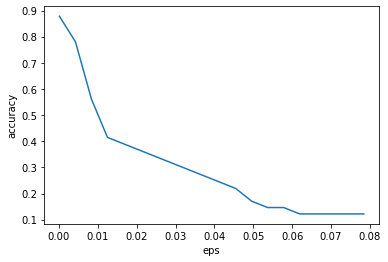

In [19]:
plt.plot(eps, accuracyFGSM)
plt.xlabel("eps")
plt.ylabel("accuracy")
plt.savefig("FGSM.png", dpi=300, bbox_inches='tight')

In [21]:
def plot_gallery(images, titles, h=62, w=47, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i+1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(Name[np.argmax(titles[i])], size=12)
        plt.xticks(())
        plt.yticks(())

def plot_image(image, title):
    """Helper function to plot a gallery of portraits"""
    plt.matshow(image, cmap=plt.cm.gray)
    plt.title(Name[np.argmax(title)], size=12)
    plt.xticks(())
    plt.yticks(())

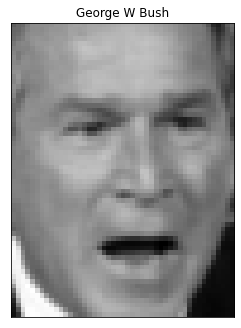

In [22]:
k = 1
plot_image(testx[k, :], testy[k])

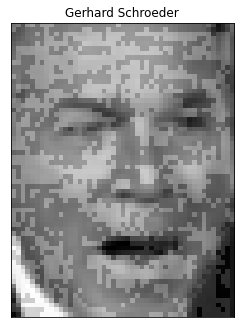

In [23]:
plot_image(x_test_adv[k, :], model.predict(x_test_adv)[k])

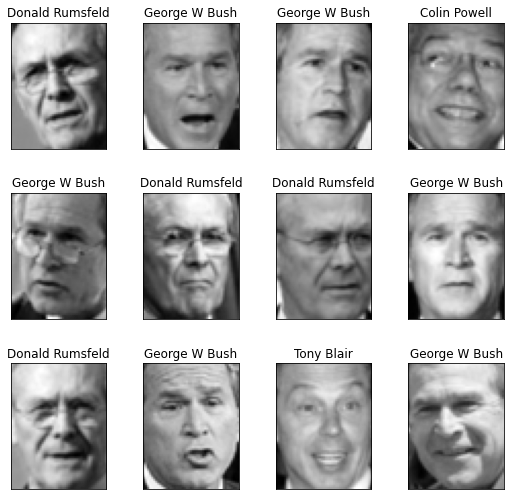

In [24]:
plot_gallery(testx, testy)

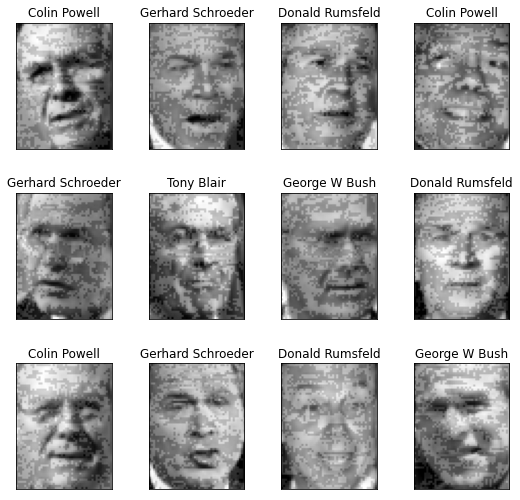

In [25]:
plot_gallery(x_test_adv, model.predict(x_test_adv))

In [107]:
# attack_cw = CarliniLInfMethod(classifier=classifier,
#                               max_iter=100,
#                               learning_rate=0.01,
#                               initial_const=1e0,
#                               largest_const=2e0)
attack_fgsm = FastGradientMethod(estimator=classifier, eps=1/255)
# x_test_adv = attack_cw.generate(x_test)
# x_train_adv = attack_cw.generate(x_train)
x_train_adv = attack_fgsm.generate(x_train)

In [108]:
# loss_test, accuracy_test = model.evaluate(x_test_adv, y_test)
# perturbation = np.mean(np.abs((x_test_adv - x_test)))
# print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
# print('Average perturbation: {:4.2f}'.format(perturbation))

loss_test, accuracy_test = model.evaluate(x_train_adv, y_train)
perturbation = np.mean(np.abs((x_train_adv - x_train)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

Accuracy on adversarial test data: 100.00%
Average perturbation: 0.00


In [109]:
# plot_gallery(testx, testy)

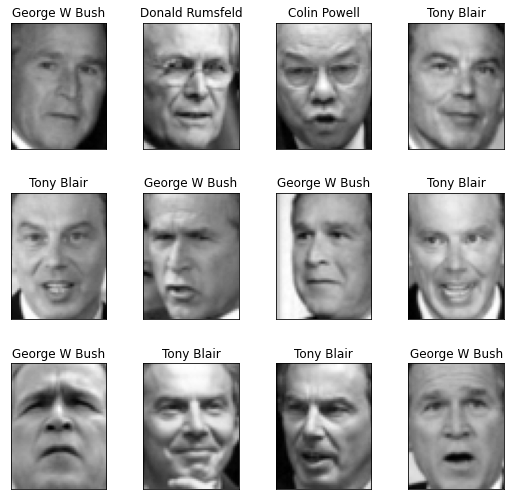

In [110]:
plot_gallery(x_train_adv, model.predict(x_train_adv))

In [111]:
np.append(x_train, x_train_adv[::2, :]).reshape(-1, 62, 47, 1).shape

(240, 62, 47, 1)

In [112]:
# attack_cw = CarliniLInfMethod(classifier=classifier,
#                               max_iter=100,
#                               learning_rate=0.01,
#                               initial_const=1e0,
#                               largest_const=2e0)
x_adv = attack_fgsm.generate(x_train[::5, :])
y_adv = model.predict(x_adv)

In [113]:
x_adv.shape, y_adv.shape, x_adv.shape, y_adv.shape

((32, 62, 47, 1), (32, 5), (32, 62, 47, 1), (32, 5))

In [114]:
loss_test, accuracy_test = model.evaluate(x_adv, y_train[::5, :])
perturbation = np.mean(np.abs((x_adv - x_train[::5, :])))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

Accuracy on adversarial test data: 100.00%
Average perturbation: 0.00


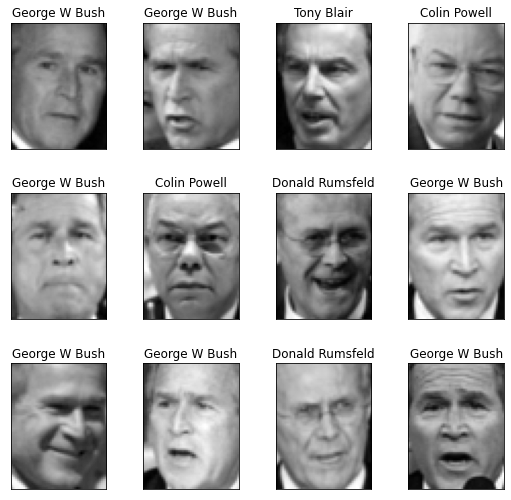

In [115]:
plot_gallery(x_adv, y_adv)

In [116]:
x_add_adv_data = np.append(x_train, x_adv).reshape(-1, 62, 47, 1)
y_add_adv_data = np.append(y_train, model.predict(x_adv)).reshape(-1, 5)
x_add_adv_data.shape, y_add_adv_data.shape

((192, 62, 47, 1), (192, 5))

In [117]:
model.fit(x_add_adv_data,y_add_adv_data, validation_data=(testx,testy),epochs=100, batch_size=32)

Train on 192 samples, validate on 41 samples
Epoch 1/100
192/192 [==============================] - 0s 973us/sample - loss: 9.6597e-04 - accuracy: 1.0000 - val_loss: 1.4121 - val_accuracy: 0.7561
Epoch 2/100
192/192 [==============================] - 0s 661us/sample - loss: 9.6558e-04 - accuracy: 1.0000 - val_loss: 1.4136 - val_accuracy: 0.7561
Epoch 3/100
192/192 [==============================] - 0s 702us/sample - loss: 9.6520e-04 - accuracy: 1.0000 - val_loss: 1.4145 - val_accuracy: 0.7561
Epoch 4/100
192/192 [==============================] - 0s 770us/sample - loss: 9.6484e-04 - accuracy: 1.0000 - val_loss: 1.4151 - val_accuracy: 0.7561
Epoch 5/100
192/192 [==============================] - 0s 724us/sample - loss: 9.6456e-04 - accuracy: 1.0000 - val_loss: 1.4156 - val_accuracy: 0.7561
Epoch 6/100
192/192 [==============================] - 0s 702us/sample - loss: 9.6424e-04 - accuracy: 1.0000 - val_loss: 1.4158 - val_accuracy: 0.7561
Epoch 7/100
192/192 [============================

192/192 [==============================] - 0s 713us/sample - loss: 9.5976e-04 - accuracy: 1.0000 - val_loss: 1.4350 - val_accuracy: 0.7561
Epoch 55/100
192/192 [==============================] - 0s 661us/sample - loss: 9.5971e-04 - accuracy: 1.0000 - val_loss: 1.4353 - val_accuracy: 0.7561
Epoch 56/100
192/192 [==============================] - 0s 714us/sample - loss: 9.5966e-04 - accuracy: 1.0000 - val_loss: 1.4358 - val_accuracy: 0.7561
Epoch 57/100
192/192 [==============================] - 0s 712us/sample - loss: 9.5963e-04 - accuracy: 1.0000 - val_loss: 1.4363 - val_accuracy: 0.7561
Epoch 58/100
192/192 [==============================] - 0s 727us/sample - loss: 9.5959e-04 - accuracy: 1.0000 - val_loss: 1.4366 - val_accuracy: 0.7561
Epoch 59/100
192/192 [==============================] - 0s 728us/sample - loss: 9.5954e-04 - accuracy: 1.0000 - val_loss: 1.4371 - val_accuracy: 0.7561
Epoch 60/100
192/192 [==============================] - 0s 706us/sample - loss: 9.5950e-04 - accuracy

In [118]:
x_adv.shape, y_train[::5, :].shape

((32, 62, 47, 1), (32, 5))

In [119]:
loss_test, accuracy_test = model.evaluate(x_adv, y_train[::5, :])
perturbation = np.mean(np.abs((x_adv - x_train[::5, :])))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

Accuracy on adversarial test data: 100.00%
Average perturbation: 0.00


In [120]:
loss_test, accuracy_test = model.evaluate(x_test, y_test)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy on test data: 75.61%


In [121]:
# attack_fgsm = FastGradientMethod(estimator=classifier, eps=10/255)
eps = np.linspace(1e-4, 20/255, 20)
# eps = [1/255]
accuracyFGSM_after = []
for _eps in eps:
    attack_fgsm = FastGradientMethod(estimator=classifier, eps=_eps)
    x_test_adv = attack_fgsm.generate(x_test)
    loss_test, accuracy_test = model.evaluate(x_test_adv, y_test)
    accuracyFGSM_after.append(accuracy_test)
    print("eps: {}, accuracy: {}".format(_eps, accuracy_test))

eps: 0.0001, accuracy: 0.7560976147651672
eps: 0.004222703818369453, accuracy: 0.585365891456604
eps: 0.008345407636738906, accuracy: 0.5121951699256897
eps: 0.012468111455108358, accuracy: 0.3658536672592163
eps: 0.01659081527347781, accuracy: 0.292682945728302
eps: 0.020713519091847266, accuracy: 0.17073170840740204
eps: 0.024836222910216716, accuracy: 0.17073170840740204
eps: 0.02895892672858617, accuracy: 0.12195122241973877
eps: 0.03308163054695563, accuracy: 0.12195122241973877
eps: 0.03720433436532508, accuracy: 0.12195122241973877
eps: 0.041327038183694535, accuracy: 0.12195122241973877
eps: 0.04544974200206399, accuracy: 0.09756097942590714
eps: 0.049572445820433436, accuracy: 0.09756097942590714
eps: 0.05369514963880289, accuracy: 0.09756097942590714
eps: 0.057817853457172344, accuracy: 0.09756097942590714
eps: 0.0619405572755418, accuracy: 0.09756097942590714
eps: 0.06606326109391125, accuracy: 0.09756097942590714
eps: 0.0701859649122807, accuracy: 0.09756097942590714
eps: 0

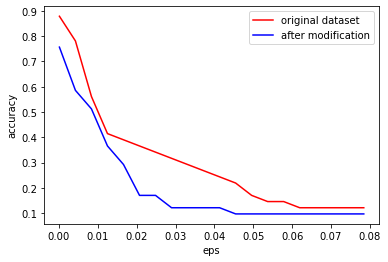

In [123]:
plt.plot(eps, accuracyFGSM, color="r", label="original dataset")
plt.plot(eps, accuracyFGSM_after, color="b", label="after modification")

plt.xlabel("eps")
plt.ylabel("accuracy")
plt.legend()
# plt.savefig("FGSM.png", dpi=300, bbox_inches='tight')

In [52]:
model.fit(trainx,trainy, validation_data=(testx,testy),epochs=100, batch_size=32)

Train on 160 samples, validate on 41 samples
Epoch 1/100
160/160 [==============================] - 0s 1ms/sample - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.8602 - val_accuracy: 0.8293
Epoch 2/100
160/160 [==============================] - 0s 693us/sample - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.8805 - val_accuracy: 0.8537
Epoch 3/100
160/160 [==============================] - 0s 660us/sample - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.8930 - val_accuracy: 0.7805
Epoch 4/100
160/160 [==============================] - 0s 717us/sample - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.9117 - val_accuracy: 0.7805
Epoch 5/100
160/160 [==============================] - 0s 811us/sample - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.9289 - val_accuracy: 0.7805
Epoch 6/100
160/160 [==============================] - 0s 862us/sample - loss: 9.4489e-04 - accuracy: 1.0000 - val_loss: 0.9356 - val_accuracy: 0.7805
Epoch 7/100
160/160 [==============================] - 0s 761us/sample 

Epoch 55/100
160/160 [==============================] - 0s 750us/sample - loss: 2.9906e-04 - accuracy: 1.0000 - val_loss: 0.9961 - val_accuracy: 0.7805
Epoch 56/100
160/160 [==============================] - 0s 757us/sample - loss: 2.9556e-04 - accuracy: 1.0000 - val_loss: 0.9967 - val_accuracy: 0.7805
Epoch 57/100
160/160 [==============================] - 0s 700us/sample - loss: 2.9159e-04 - accuracy: 1.0000 - val_loss: 0.9983 - val_accuracy: 0.7805
Epoch 58/100
160/160 [==============================] - 0s 673us/sample - loss: 2.8794e-04 - accuracy: 1.0000 - val_loss: 0.9996 - val_accuracy: 0.7805
Epoch 59/100
160/160 [==============================] - 0s 677us/sample - loss: 2.8441e-04 - accuracy: 1.0000 - val_loss: 1.0003 - val_accuracy: 0.7805
Epoch 60/100
160/160 [==============================] - 0s 667us/sample - loss: 2.8053e-04 - accuracy: 1.0000 - val_loss: 1.0010 - val_accuracy: 0.7805
Epoch 61/100
160/160 [==============================] - 0s 757us/sample - loss: 2.7710e-

In [ ]:
loss_test, accuracy_test = model.evaluate(x_test, y_test)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

In [ ]:
attack = DeepFool(classifier,
                 epsilon=1/255,
                 )

# Применение атаки на тестовом наборе данных
x_test_adv = attack.generate(x_test)

# Оценка точности классификатора на защищенных примерах
loss_test, accuracy_test = model.evaluate(x_test_adv, y_test)
perturbation = np.mean(np.abs((x_test_adv - x_test)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))